In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import time

from IPython import display

# Load and Prepare MNIST Dataset

In [266]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [267]:
# Reshape
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalize
train_images = (train_images - 127.5) / 127.5 
test_images = (test_images - 127.5) / 127.5

# To categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


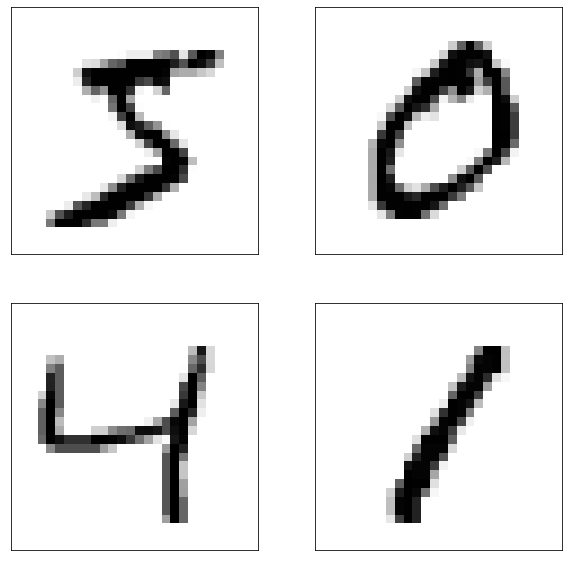

In [268]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(axis=2), cmap=plt.cm.binary)
plt.show()

# Feed Forward Deep Neural Network (CNN)

## Create CNN to train MNIST dataset

In [269]:
def make_baseline_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
#     model.add(layers.Dense(10))

    return model

In [270]:
baseline = make_baseline_model()
baseline.add(layers.Dense(10, activation='softmax'))

## Compile the model

In [271]:
baseline.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [272]:
baseline.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6272)            

## Train the model

In [273]:
baseline.fit(train_images, train_labels, batch_size=256, epochs=10)

Epoch 1/10
235/235 [==============================] - 40s 171ms/step - loss: 0.3215 - accuracy: 0.9030
Epoch 2/10
235/235 [==============================] - 46s 196ms/step - loss: 0.1159 - accuracy: 0.9659
Epoch 3/10
235/235 [==============================] - 46s 197ms/step - loss: 0.0925 - accuracy: 0.9720
Epoch 4/10
235/235 [==============================] - 46s 198ms/step - loss: 0.0781 - accuracy: 0.9758
Epoch 5/10
235/235 [==============================] - 38s 164ms/step - loss: 0.0713 - accuracy: 0.9775
Epoch 6/10
235/235 [==============================] - 38s 160ms/step - loss: 0.0629 - accuracy: 0.9805
Epoch 7/10
235/235 [==============================] - 32s 135ms/step - loss: 0.0610 - accuracy: 0.9808
Epoch 8/10
235/235 [==============================] - 41s 174ms/step - loss: 0.0552 - accuracy: 0.9823
Epoch 9/10
235/235 [==============================] - 42s 177ms/step - loss: 0.0513 - accuracy: 0.9837
Epoch 10/10
235/235 [==============================] - 46s 194ms/step - l

## Evaluate accuracy

In [274]:
test_loss, test_acc = baseline.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 0.0461 - accuracy: 0.9848

Test accuracy: 0.9847999811172485


# Create Discriminator and Generator Networks

## Generator

In [86]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

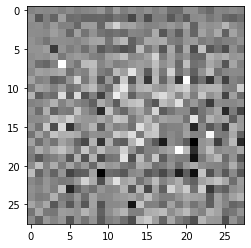

In [87]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [282]:
generator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 7, 128)       

## Discriminator

In [168]:
discriminator = make_baseline_model()
discriminator.add(layers.Dense(1))

discriminator.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6272)            

In [169]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-7.5450385e-05]], shape=(1, 1), dtype=float32)


# Define Loss and Optimization

In [90]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [91]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [92]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [93]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [94]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train

In [170]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [96]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [97]:
def train(dataset, epochs):
    loss = []
    for epoch in range(epochs):
        epoch_loss = []
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_loss.append([gen_loss, disc_loss])
        loss.append(epoch_loss)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    loss.append(epoch_loss)
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    return loss

In [98]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

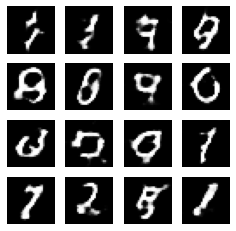

In [171]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

loss = train(train_dataset, EPOCHS)

## Evaluate Models

In [172]:
l = np.array(loss)

In [175]:
l.shape

(101, 40, 2)

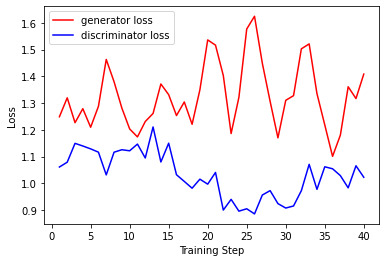

In [200]:
t = range(1,41)

gen_loss = l[100,:,0]
disc_loss = l[100,:,1]

plt.plot(t, gen_loss, 'r', t, disc_loss, 'b')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend(['generator loss', 'discriminator loss'])
plt.show()

## Fine tune discriminator model

In [275]:
model = tf.keras.Sequential()

for layer in discriminator.layers[:-1]: # go through until last layer
    layer.trainable = False
    model.add(layer)
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6272)            

In [276]:
model.fit(train_images, train_labels, batch_size=256, epochs=10)

Epoch 1/10
235/235 [==============================] - 15s 63ms/step - loss: 0.8548 - accuracy: 0.8064
Epoch 2/10
235/235 [==============================] - 15s 62ms/step - loss: 0.4339 - accuracy: 0.8843
Epoch 3/10
235/235 [==============================] - 18s 76ms/step - loss: 0.3681 - accuracy: 0.8987
Epoch 4/10
235/235 [==============================] - 19s 79ms/step - loss: 0.3342 - accuracy: 0.9062
Epoch 5/10
235/235 [==============================] - 19s 80ms/step - loss: 0.3154 - accuracy: 0.9101
Epoch 6/10
235/235 [==============================] - 19s 79ms/step - loss: 0.3002 - accuracy: 0.9136
Epoch 7/10
235/235 [==============================] - 19s 81ms/step - loss: 0.2883 - accuracy: 0.9177
Epoch 8/10
235/235 [==============================] - 17s 72ms/step - loss: 0.2784 - accuracy: 0.9207
Epoch 9/10
235/235 [==============================] - 16s 67ms/step - loss: 0.2714 - accuracy: 0.9212
Epoch 10/10
235/235 [==============================] - 19s 81ms/step - loss: 0.263

In [277]:
disc_loss, disc_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', disc_acc)

313/313 - 2s - loss: 0.2185 - accuracy: 0.9387

Test accuracy: 0.9387000203132629


In [278]:
from sklearn import metrics

pred = model.predict(test_images)

true = np.argmax(test_labels, axis=1)
pred = np.argmax(pred, axis=1)

classification_metric = metrics.classification_report(true, pred)
print(classification_metric)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.95      0.99      0.97      1135
           2       0.96      0.91      0.93      1032
           3       0.93      0.94      0.93      1010
           4       0.92      0.96      0.94       982
           5       0.97      0.89      0.92       892
           6       0.94      0.97      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.92      0.90      0.91       974
           9       0.92      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



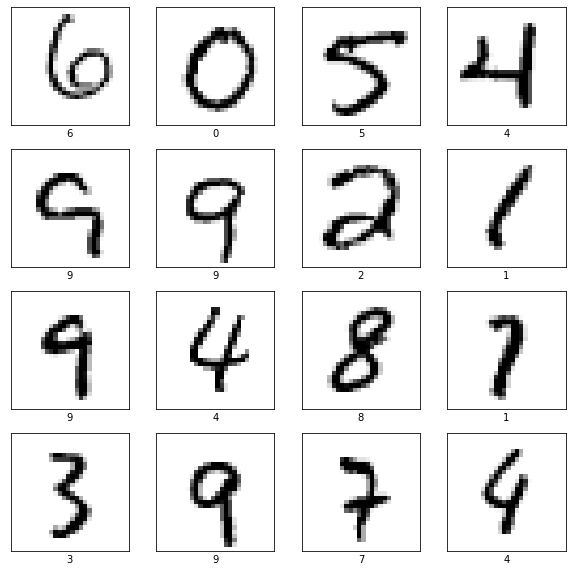

In [232]:
offset = 100

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i+offset].squeeze(axis=2), cmap=plt.cm.binary)
    plt.xlabel(pred[i+offset])
plt.show()

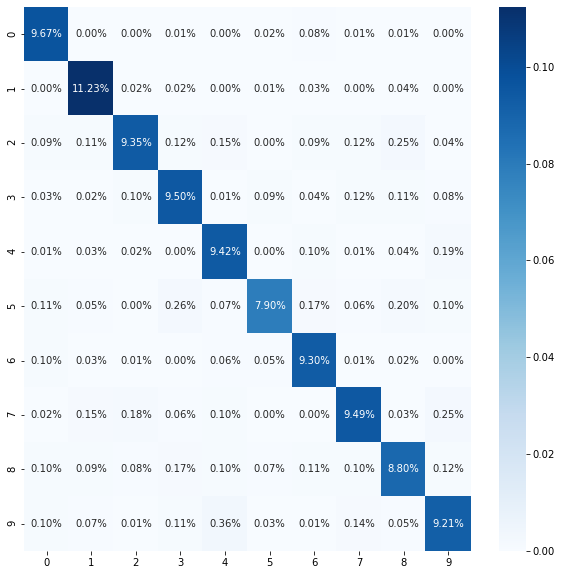

In [281]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(true, pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', ax=ax)

# Create GIFs

In [26]:
# To create GIFs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-jbnco86p
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-jbnco86p
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0b5de8b6909eadaaa5c4854d80ed8e75afd3083a4_-py3-none-any.whl size=142989 sha256=cb66ce8e4e3afa80d7c63472b418ac67efa7ab114e62b7604b5e9cb4eff9adef
  Stored in directory: /tmp/pip-ephem-wheel-cache-wues058h/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [217]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

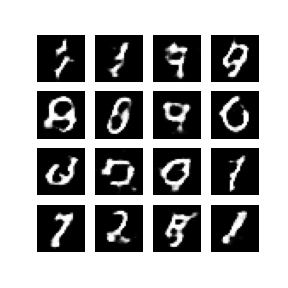

In [218]:
display_image(EPOCHS)

In [219]:
import imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


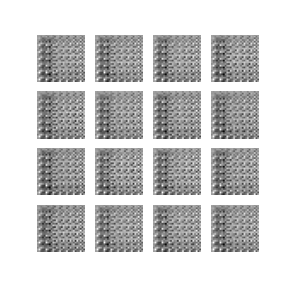

In [142]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)